In [1]:
import pypulseq as pp
import numpy as np
import MRzeroCore as mr0
import numpy as np
import torch
import matplotlib.pyplot as plt

# Example System Setup
system = pp.Opts(max_grad=28,             
                 grad_unit='mT/m',                   
                 max_slew=150,                        
                 slew_unit='T/m/s',     
                 rf_ringdown_time=20e-6,                                     
                 rf_dead_time=100e-6,             
                 adc_dead_time=20e-6,   
                )

In [2]:
seq = pp.Sequence(system)
fov, Nread, Nphase, slice_thickness = 1000e-3, 128, 1, 8e-3

rf, _, _ = pp.make_sinc_pulse(flip_angle= 90.0 * np.pi / 180, duration=1e-3, slice_thickness=8e-3,
                              apodization=0.5, time_bw_product=4, system=system, return_gz=True)


gx = pp.make_trapezoid(channel='x', flat_area=Nread, flat_time=20e-3, system=system)
gx_ = pp.make_trapezoid(channel='x', area = - gx.area, duration=20e-3, system=system)
gx_pre = pp.make_trapezoid(channel='x', duration=2e-3, area = - gx.area / 2 , system=system)

adc = pp.make_adc(num_samples=Nread, duration=20e-3, system=system, delay = gx.rise_time)

In [3]:
# Single Echo
seq.add_block(rf)
seq.add_block(gx_pre)
seq.add_block(gx, adc)

In [63]:
# Multi Echo
seq.add_block(rf)
seq.add_block(gx_pre)

for _ in range(2):
    seq.add_block(gx, adc)
    seq.add_block(gx_, adc)

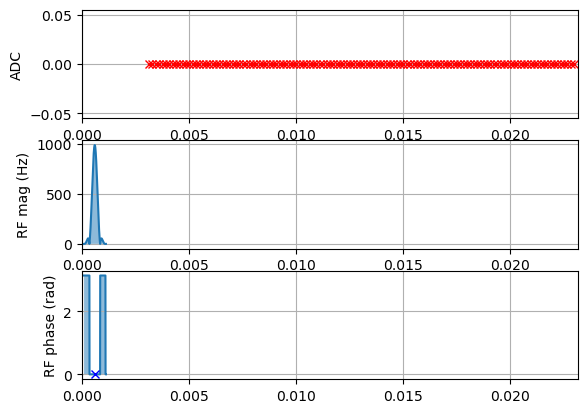

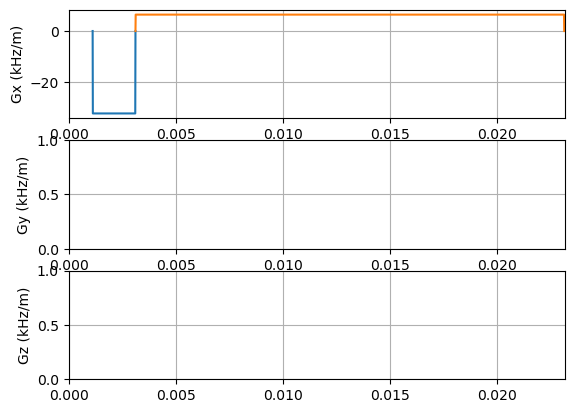

In [4]:
sp_adc, t_adc = mr0.util.pulseq_plot(seq)

In [5]:
Name = 'Gradient Echo 1D'
experiment_id = 'GE_1D'

seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', Name)
seq.write('../out/' + experiment_id + '.seq')

In [6]:
seq0 = mr0.Sequence.import_file('../out/' + experiment_id + '.seq')

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


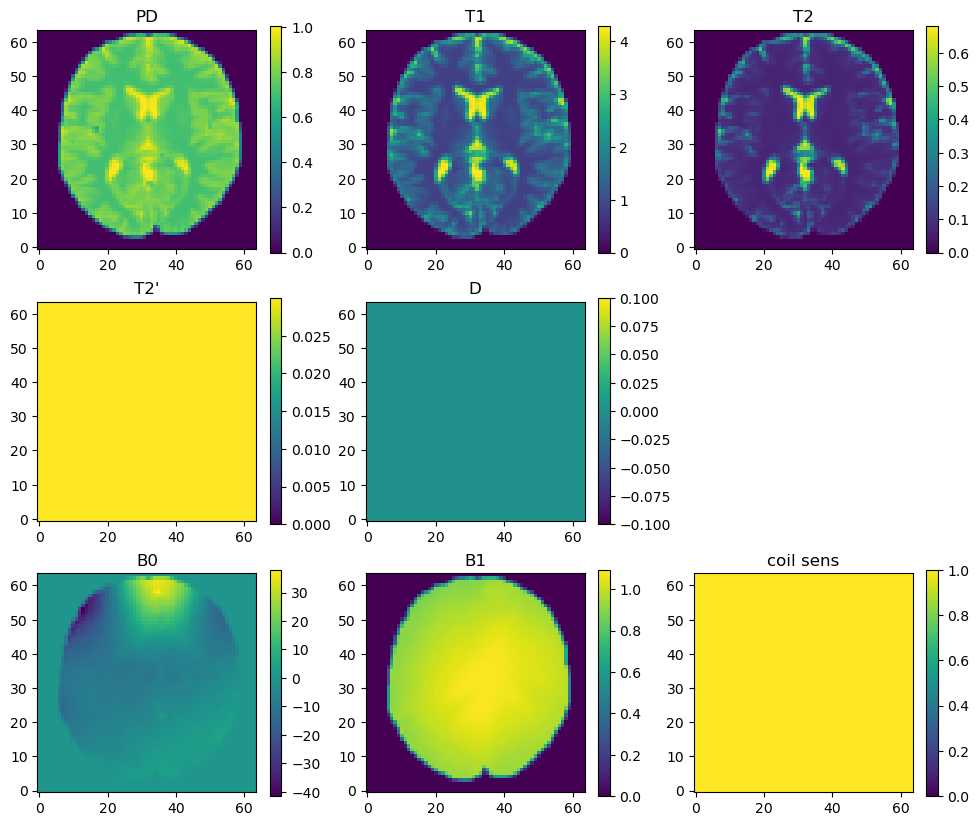

In [7]:
sz = [64,64]

obj_p = mr0.VoxelGridPhantom.load_mat('../data/numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)

obj_p.B0 *= 1
obj_p.D *= 0

obj_p.plot()

obj_p.size=torch.tensor([fov, fov, slice_thickness]) 
obj_p = obj_p.build()

In [8]:
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p)

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.000019167 s
Compute Graph
Computing Graph: 0.000011625 s
Analyze Graph
Analyzing Graph: 0.000000834 s
Converting Rust -> Python: 0.000005583 s
<<<< Rust <<<<
Calculating repetition 1 / 1 - done


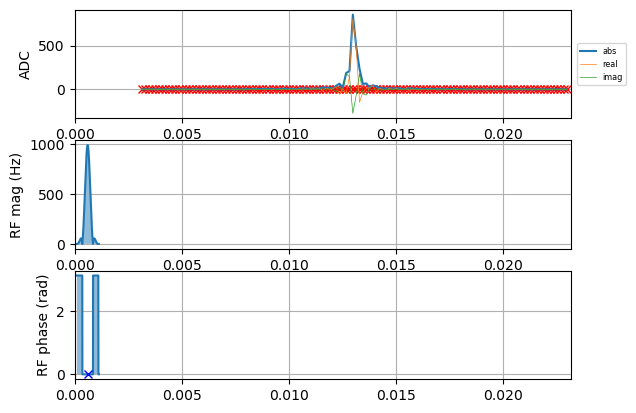

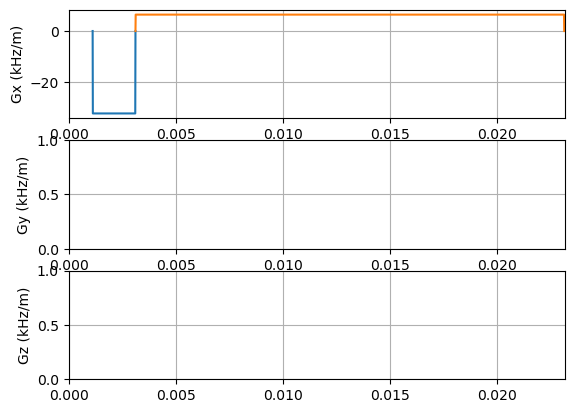

In [9]:
sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, signal=signal.numpy())

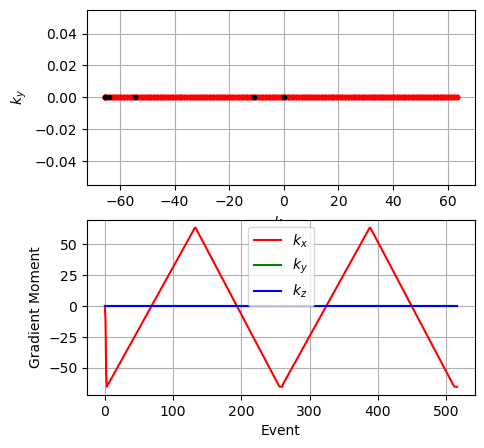

In [70]:
seq0.plot_kspace_trajectory()